In [32]:
include("../src/QuantumEvolution.jl")
using LaTeXStrings
using PyPlot

In [17]:
# Trajectory and plotting function
function solve(inc, init, dt, T, fs, plot_title; readout=false, n=1)
    figure(1)
    if n==1
        out = trajectory(inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = trajectory(inc, init, T, fs..., dt=dt)
        plot(out[1].t,out[1],label=L"$x$",color="r")
        plot(out[2].t,out[2],label=L"$y$",color="g")
        plot(out[3].t,out[3],label=L"$z$",color="b")
        plot(out[3].t,out[1].^2 .+ out[2].^2 .+ out[3].^2,label=L"$x^2 + y^2 + z^2$",color="purple")
    else
        out = ensemble(1, inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = ensemble(n, inc, init, T, fs..., dt=dt)
        m1 = mean(out[1]); m2 = mean(out[2]); m3 = mean(out[3]);
        s1 = std(out[1]); s2 = std(out[2]); s3 = std(out[3]);
        plot(out[1].t,m1,label=L"$x$",color="r")
        plot(out[2].t,m2,label=L"$y$",color="g")
        plot(out[3].t,m3,label=L"$z$",color="b")
        fill_between(out[1].t, m1-s1, m1+s1, color="r", alpha=0.2, antialiased=true)
        fill_between(out[2].t, m2-s2, m2+s2, color="g", alpha=0.2, antialiased=true)
        fill_between(out[3].t, m3-s3, m3+s3, color="b", alpha=0.2, antialiased=true)
    end
    ax = gca()
    xlabel(L"$t (2\pi/\Omega)$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    show()
    if readout
        figure(2)
        if n==1
            plot(out[4].t,out[4],label=L"$r_z$",color="k")
        else
            m4 = mean(out[4]); s4 = std(out[4]); 
            plot(out[4].t,m4,label=L"$r_z$",color="k")
            fill_between(out[4].t, m4-s4, m4+s4, color="k", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t (2\pi/\Omega)$")
        ylabel("Stochastic readout")
        title(plot_title*" Readout")
        legend()
        show()
    end
end;

In [29]:
# Single Qubit

Ω  = 4π # Rabi frequency
τ = 3.0 # Measurement collapse timescale
Γ = τ # Measurement dephasing rate
dt = 1e-4 # Simulation timestep (coarse to show method precision)
T = (0.0, 6τ) # Time duration of simulation
η = 0.1

# Definitions
q = SpinBasis(1//2)
z = spinup(q)
zm = spindown(q)
y = (z + im*zm)/sqrt(2)
x = (z + zm)/sqrt(2)
Z = dm(z)
Y = dm(y)
X = dm(x)

# Initial condition
init = Z

# Time-dependent Hamiltonian
H(t) = 2exp(-(t-3τ)^2/2)/sqrt(2π)*(Ω/2)*Y

# Measurement dephasing
DM = [sqrt(Γ/2)*Z]
# Stochastic monitoring (quantum-limited efficiency)
SM = [(Z, τ, η)]

# Bloch coordinate expectation values 
fs = collect(ρ -> 2real(expect(ρ, l) - 0.5) for l in [X, Y, Z]);

┌ Info: Trajectory: steps = 
│   N - 1 = 180000
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ Main /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QEvolution.jl:437
┌ Info: Readout: values = 
│   Nr = 1
└ @ Main /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QEvolution.jl:438


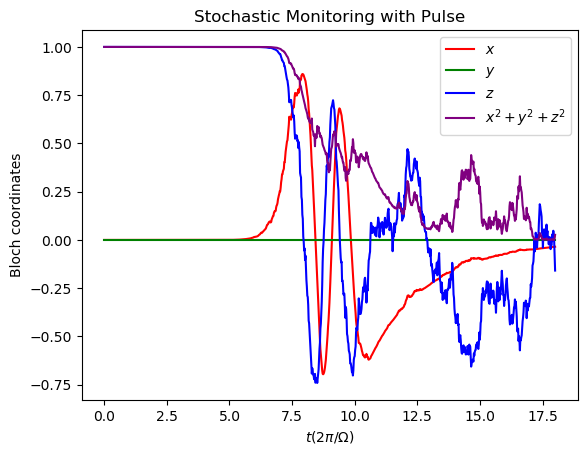

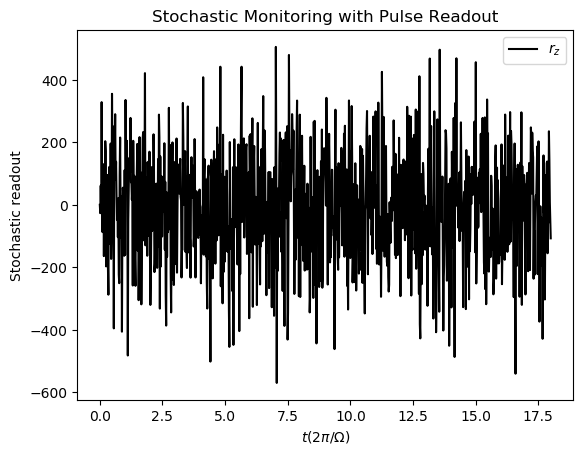

  4.742301 seconds (36.87 M allocations: 2.800 GiB, 16.68% gc time)


┌ Info: Time elapsed: 
│   elapsed = 4.741831064224243
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 37960.019570930825
└ @ Main /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QEvolution.jl:455


In [30]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse", readout=true)